# Task description

Operators like joins, selections and missing value imputaters can cause *data distribution issues*, which can heavily impact the performance of our model. Mlinspect helps with identifying such issues by offering an inspection to calculate historams for sensitive groups. Thanks to our annotation propagation, this works even if the group columns are projected out at some point. To automatically check for significant changes and compute the histograms, we used the `no_bias_introduced_for(...)` constraint.

We want to find out if preprocessing operations in this pipeline introduce bias and if so, which groups are effected.
The pipeline we want to analyse can be found using the path `os.path.join(str(get_project_root()), "example_pipelines", "healthcare", "healthcare.py")`. Its code:

```python
"""
An example pipeline
"""
import os
import warnings

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from example_pipelines.healthcare.healthcare_utils import MyW2VTransformer, create_model
from mlinspect.utils import get_project_root

# FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit
warnings.filterwarnings('ignore')

COUNTIES_OF_INTEREST = ['county2', 'county3']

# load input data sources (data generated with https://www.mockaroo.com as a single file and then split into two)
patients = pd.read_csv(os.path.join(str(get_project_root()), "example_pipelines", "healthcare",
                                    "healthcare_patients.csv"), na_values='?')
histories = pd.read_csv(os.path.join(str(get_project_root()), "example_pipelines", "healthcare",
                                     "healthcare_histories.csv"), na_values='?')

# combine input data into a single table
data = patients.merge(histories, on=['ssn'])

# compute mean complications per age group, append as column
complications = data.groupby('age_group').agg(mean_complications=('complications', 'mean'))

data = data.merge(complications, on=['age_group'])

# target variable: people with a high number of complications
data['label'] = data['complications'] > 1.2 * data['mean_complications']

# project data to a subset of attributes
data = data[['smoker', 'last_name', 'county', 'num_children', 'race', 'income', 'label']]

# filter data
data = data[data['county'].isin(COUNTIES_OF_INTEREST)]

# define the feature encoding of the data
impute_and_one_hot_encode = Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('encode', OneHotEncoder(sparse=False, handle_unknown='ignore'))
    ])

featurisation = ColumnTransformer(transformers=[
    ("impute_and_one_hot_encode", impute_and_one_hot_encode, ['smoker', 'county', 'race']),
    ('word2vec', MyW2VTransformer(min_count=2), ['last_name']),
    ('numeric', StandardScaler(), ['num_children', 'income'])
])

# define the training pipeline for the model
neural_net = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1, verbose=0, input_dim=109)
pipeline = Pipeline([
    ('features', featurisation),
    ('learner', neural_net)])

# train-test split
train_data, test_data = train_test_split(data, random_state=0)
# model training
model = pipeline.fit(train_data, train_data['label'])
# model evaluation
print(model.score(test_data, test_data['label']))
```

 This is using a synthetic benchmark dataset we created. 

# Step 1/3: Add inspections and execute the pipeline

The central entry point of mlinspect is the `PipelineInspector`. To use mlinspect, we use it and pass it the path to the runnable version of the example pipeline. Here, we have the example pipeline in a `.py` file. 

First, we define the check we want mlinspect to run. In this example, we only use 1 check to compute histograms of sensitive groups and verify operators cause no significant distribution changes.

Then, we execute the pipeline. Mlinspect returns a `InspectorResult`, which contains the output of our check. 

In [1]:
import os
from mlinspect.utils import get_project_root

from mlinspect import PipelineInspector
from mlinspect.checks import NoBiasIntroducedFor

HEALTHCARE_FILE_PY = os.path.join(str(get_project_root()), "example_pipelines", "healthcare", "healthcare.py")

inspector_result = PipelineInspector\
    .on_pipeline_from_py_file(HEALTHCARE_FILE_PY) \
    .add_check(NoBiasIntroducedFor(["age_group", "race"])) \
    .execute()

check_results = inspector_result.check_to_check_results

0.5205479264259338


# Step 2/3: Overview of the check results
## Did our check find issues?

Let us look at the `check_result` to see whether some constraints failed. We see that some constraints failed and investigate which ones. As all 3 failed, we will look into each result in detail.

Our check already filtered all operators that can cause data distribution issues. Now we will use the result to create list with all distribution changes and visualize them. Using this, we can investigate the changes of the different operators one at a time.

In [2]:
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

check_result_df = PipelineInspector.check_results_as_data_frame(check_results)
display(check_result_df)

,check_name,status,description
0,"NoBiasIntroducedFor((('age_group', 'race'), -0.3))",CheckStatus.FAILURE,"A Selection causes a min_relative_ratio_change of 'race' by -0.5678035982008997, a value below the configured minimum threshold -0.3!"


In [3]:
no_bias_check_result = check_results[NoBiasIntroducedFor(['age_group', 'race'])]

distribution_changes_overview_df = NoBiasIntroducedFor.get_distribution_changes_overview_as_df(no_bias_check_result)
display(distribution_changes_overview_df)

dag_node_distribution_changes_list = list(no_bias_check_result.bias_distribution_change.items())

,DagNode OperatorType,DagNode CodeReference,DagNode Module,DagNode Description,'age_group' distribution change above test threshold,'race' distribution change above test threshold
0,OperatorType.JOIN,"CodeReference(lineno=29, col_offset=7, end_lineno=29, end_col_offset=44)","(pandas.core.frame, merge)",on ['ssn'],False,False
1,OperatorType.JOIN,"CodeReference(lineno=34, col_offset=7, end_lineno=34, end_col_offset=50)","(pandas.core.frame, merge)",on ['age_group'],False,False
2,OperatorType.SELECTION,"CodeReference(lineno=43, col_offset=7, end_lineno=43, end_col_offset=54)","(pandas.core.frame, __getitem__, Selection)",Select by series,False,True
3,OperatorType.TRANSFORMER,"CodeReference(lineno=47, col_offset=19, end_lineno=47, end_col_offset=58)","(sklearn.impute._base, SimpleImputer, Pipeline)","Imputer (SimpleImputer), Column: 'race'",False,False


# Step 3/3: Detailed Investigation

As we can see, the selection causes the check to fail because of the `race` attribute. Still, we will investigate all of the operator changes to see if there is something else our check may have missed because the change was slightly below the change threshold of the `NoBiasIntroducedFor(["race", "sex"])` (which can be configured by the user).

## Let's see how different operations might change proportions of groups in data

We start by looking at the first operator that could heavily change the proportion of groups in our data, the `.dropna()` selection. Then, ...


 OperatorType.SELECTION CodeReference(lineno=43, col_offset=7, end_lineno=43, end_col_offset=54) ('pandas.core.frame', '__getitem__', 'Selection') Select by series 

 Column 'age_group', acceptable change: True, min_relative_ratio_change: -0.016871921182266037


,sensitive_column,count_before,count_after,ratio_before,ratio_after,relative_ratio_change
0,group1,281,92,0.316798,0.317241,0.001399
1,group2,298,99,0.335964,0.341379,0.016119
2,group3,308,99,0.347238,0.341379,-0.016872


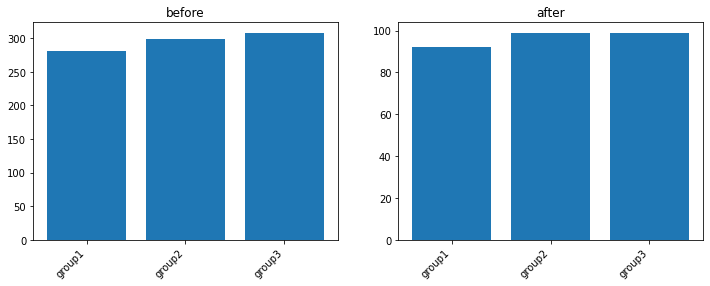


 Column 'race', acceptable change: False, min_relative_ratio_change: -0.5678035982008997


,sensitive_column,count_before,count_after,ratio_before,ratio_after,relative_ratio_change
0,nan,95,34,0.107103,0.117241,0.094664
1,race1,284,117,0.320180,0.403448,0.260066
2,race2,232,100,0.261556,0.344828,0.318371
3,race3,276,39,0.311161,0.134483,-0.567804


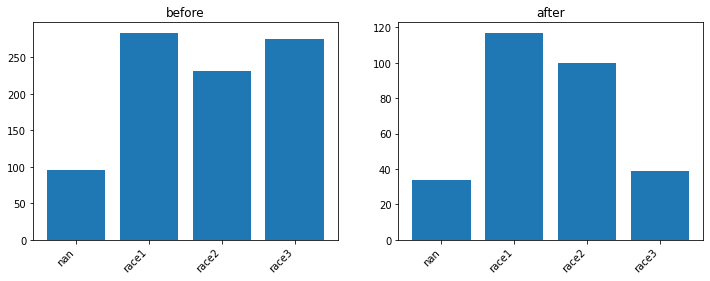

In [4]:
# Select the DagNode we want to look at by index
dag_node, distribution_changes = dag_node_distribution_changes_list[2]

# Investige the changes
print('\033[1m', dag_node.operator_type, dag_node.code_reference, dag_node.module, dag_node.description, '\033[0m')
for column, distribution_change in distribution_changes.items():
    print("")
    print("\033[1m Column '{}'\033[0m, acceptable change: {}, min_relative_ratio_change: {}".format(column, distribution_change.acceptable_change, distribution_change.min_relative_ratio_change))
    display(distribution_change.before_and_after_df)
    NoBiasIntroducedFor.plot_distribution_change_histograms(distribution_change)

**The `most-frequent` imputation amplifies the existing `race` imbalance!**

# Your answer: Did we find operators that introduce bias? How much did the distribution change?

We conclude, gender bias can be found.